In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)
import pickle

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [59]:
path = '../data/df_tweetscov19_sample_200000_23.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative', 'Sentiment neutral', 'Sentiment positive', 'Sentiment compound', 'Number of hashtags', 'Number od mentions', 'Text length', 'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent', 'Political polarisation (tweet based)', 'Science polarisation (tweet based)', 'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend', 'Female', 'Male' , 'Work', 'Leisure', 'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk', 'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'compare', 'Interrog', 'Number', 'Quant', 'See', 'Hear', 'Feel', 'Motion', 'Space', 'Time', 'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)', 'Reputation (user)', 'Is_deleted', 'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1254069159098322947,4e8e74c47b8950e4b3954c86732007f6,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,17,0,35.6050,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,1,1,1.0000,0.6264,True,0.0000,0.0000,0.0000,0.0000,0.0000
1,1249258619562070019,bd41ec450084d9a16582b6fccbddcc9f,0,0,-0.2710,0.7290,0.0000,-0.3818,0,0,72,1,40.0900,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,-1.0000,10,10,1.0000,1.0000,True,0.4501,-0.8319,-1.0000,0.0000,1.0000
2,1244312339756834817,4de0b1281cf756ea9707014c816679a1,0,0,-0.2100,0.4330,0.3570,0.3336,1,0,66,0,75.5000,1,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.4861,True,0.3336,0.0000,0.0000,0.0000,0.0000
3,1182296312932384768,a28f24f00de6b0aebb557d27f9c51500,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,93,0,80.0980,2,-0.1710,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,20.0000,5.0000,0.0000,0.0000,5.0000,0.0000,0.0000,15.0000,0.0000,10.0000,10.0000,0.0000,5.0000,0.0000,30.0000,5.0000,5.0000,5.0000,0.0000,0.0000,0.0000,5.0000,0.0000,10.0000,5.0000,10.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.5193,True,0.0000,0.0000,0.0000,0.0000,0.0000
4,1240046019548721156,a52194236f9679e4183863c3583c6178,0,0,-0.1310,0.8690,0.0000,-0.2755,0,1,111,1,61.2400,0,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000

In [60]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1249287514159906816,091fa447adc01c6b32465d03e6cdb248,3,6,-0.0000,0.8710,0.1290,0.6705,7,1,298,0,55.7070,0,0.0000,0.0000,0.0000,0.0000,6.9800,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,0.0000,4.6500,2.3300,0.0000,2.3300,0.0000,0.0000,9.3000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,2.3300,2.3300,6.9800,11.6300,0.0000,2.3300,0.0000,11.6300,2.3300,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,2.3300,0.0000,1.0000,0.0000,4,0,0.0000,0.2105,False,0.2144,0.4561,0.0000,-1.0000,0.0000
1,1227193153767329792,1238a8afe6354e06c19f70efe70026b0,0,0,-0.0000,0.6330,0.3670,0.7783,0,2,76,0,26.4700,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,0.0000,9.0900,9.0900,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,9.0900,0.0000,9.0900,9.0900,0.0000,9.0900,9.0900,9.0900,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,1,1,1.0000,0.2126,True,0.7783,0.0000,0.0000,0.0000,0.0000
2,1262093017847984128,992623c17d7871eaed9b555302cf45f7,0,0,-0.0000,1.0000,0.0000,0.0000,0,4,186,0,60.6740,5,1.6600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,0.0000,0.0000,0.0000,8,8,1.0000,0.1111,True,0.0000,0.0000,0.0000,0.0000,0.0000
3,1216323434617196545,12c9471ffbe204372650bb848564976a,0,0,-0.2120,0.5080,0.2800,0.3523,0,0,71,0,73.8450,1,0.2210,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,9.0900,9.0900,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,1,0,0.0000,0.6961,False,0.3523,0.0000,0.0000,0.0000,0.0000
4,1237527675570249728,afc14566840f8af31b2ea5b5ad42eda3,0,0,-0.0770,0.8060,0.1170,0.2732,0,6,177,0,65.5560,0,0.0000,0.0000,0.0000,0.0000,7.4100,0.0000,3.7000,0.0000,0.0000,0.0000,3.7000,0.0000,0.0000,0.0000,0.0000,0.0000,

In [61]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative',
       'Sentiment neutral', 'Sentiment positive', 'Sentiment compound',
       'Number of hashtags', 'Number od mentions', 'Text length',
       'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent',
       'Political polarisation (tweet based)',
       'Science polarisation (tweet based)',
       'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend',
       'Female', 'Male', 'Work', 'Leisure', 'Home', 'Money', 'Relegion',
       'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler',
       'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx',
       'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain',
       'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk',
       'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe',
       'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj',
       'Negate', 'Verb',

In [62]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)
df_tweetscov19_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
199995,1238646799734202368,3c7e6ad895b2cff2fe85a401fb66de5b,0,0,-0.0000,1.0000,0.0000,0.0000,1,0,198,0,86.7580,0,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,2.7800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,2.7800,0.0000,2.7800,5.5600,8.3300,0.0000,5.5600,5.5600,2.7800,5.5600,0.0000,0.0000,0.0000,2.7800,0.0000,2.7800,0.0000,0.0000,5.5600,8.3300,8.3300,0.0000,0.0000,0.0000,1,1,1.0000,0.1250,1,0.0000,0.0000,0.0000,0.0000,0.0000
199996,1265103731198005248,365d996702e6e748c641ace5573138ba,0,0,-0.0280,0.9150,0.0570,0.4404,0,3,319,0,59.3550,1,0.2210,0.0000,0.0000,0.0000,16.9500,0.0000,0.0000,1.6900,0.0000,1.6900,0.0000,0.0000,0.0000,0.0000,1.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0800,1.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.3900,1.6900,3.3900,3.3900,1.6900,3.3900,0.0000,0.0000,3.3900,0.0000,0.0000,1.6900,13.5600,1.6900,0.0000,0.0000,0.0000,1.6900,6.7800,5.0800,5.0800,13.5600,13.5600,6.7800,6.7800,1.6900,20.3400,1.6900,1.6900,5.0800,0.0000,1.6900,0.0000,1.6900,0.0000,0.0000,6.7800,6.7800,0.0000,0.0000,0.0000,1,1,1.0000,0.2962,1,0.4404,0.0000,0.0000,0.0000,0.0000
199997,1266923237025472512,e15cc003e9d197bed29e42ca19b825ff,0,0,-0.2590,0.7410,0.0000,-0.7906,0,2,131,0,61.4500,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.3500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.3500,0.0000,0.0000,0.0000,13.0400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13.0400,4.3500,4.3500,8.7000,4.3500,0.0000,4.3500,0.0000,0.0000,4.3500,0.0000,0.0000,4.3500,0.0000,0.0000,8.7000,4.3500,4.3500,0.0000,0.0000,0.0000,9,9,1.0000,0.1212,1,-0.5536,-0.2370,0.0000,0.0000,0.0000
199998,1214751254288719872,ad72c4516df2b041335ee1ef64829843,0,0,-0.2430,0.7570,0.0000,-0.8519,0,3,196,0,61.9060,0,0.0000,0.0000,0.0000,0.0000,17.6500,0.0000,0.0000,0.0000,0.0000,0.0000,2.9400,0.0000,0.0000,0.0000,0.0000,2.9400,2.9400,0.0000,0.0000,0.0000,0.0000,2.9400,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,2.9400,0.0000,2.9400,2.9400,0.0000,2.9400,5.8800,0.0000,2.9400,0.0000,2.9400,5.8800,2.9400,8.8200,5.8800,0.0000,0.0000,0.0000,5.8800,0.0000,0.0000,8.8200,2.9400,14.7100,5.8800,8.8200,5.8800,0.0000,17.6500,2.9400,2.9400,5.8800,0.0000,2.9400,0.0000,2.9400,0.0000,0.0000,2.9400,5.8800,0.0000,0.0000,0.0000,23,23,1.0000,0.2167,1,-0.1119,-0.7400,0.0000,0.0000,0.0000
199999,1189535572571893762,ad3d1e8f427459978f4c56c3d167234d,0,0,-0.0000,0.6940,0.3060,0.9042,1,1,234,0,64.7080,0,0.0000,0.0000,0.0000,0.0000,14.7100,2.9400,0.0000,2.9400,0.0000,2.9400,0.0000,0.0000,0.00

In [63]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)'])

In [2]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [65]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 89)
(200000,)


In [3]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [67]:
 X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [4]:
def fit_gradientboosting_clf(X,y):
    
    clf = GradientBoostingClassifier()
    clf.fit(X,y)
    return clf

In [5]:
def test_gradientboosting_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [20]:
gb_model = fit_gradientboosting_clf(X_train, y_train)

In [21]:
test_gradientboosting_clf(gb_model, X_test, y_test)

Accuracy : 0.64725


In [22]:
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59     19789
           1       0.62      0.77      0.69     20211

    accuracy                           0.65     40000
   macro avg       0.66      0.65      0.64     40000
weighted avg       0.66      0.65      0.64     40000



In [6]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

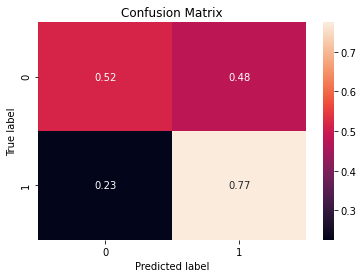

In [24]:
plot_confusion_matrix(y_test, y_pred, gb_model.classes_, 'Confusion Matrix')

In [7]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [69]:
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01, loss='exponential')
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,83,Reputation (user),0.4137
1,80,Political polarisation (user based),0.1453
2,82,Moderacy polarisation (user based),0.1382
3,0,Retweets,0.1335
4,9,Number of URLs,0.0863
5,6,Number of hashtags,0.0309
6,56,I,0.0259
7,8,Text length,0.0180
8,27,Informal,0.0046
9,21,Work,0.0021


In [20]:
f_importances = f_importances[f_importances['importance'] != 0]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_political_polarisation' 'Retweets'
 'user_moderacy_polarisation' 'URLs_num' 'Hashtags_num' 'i' 'Text_len'
 'informal' 'work' 'tweet_moderacy_polarisation_difference' 'Emoji_sent']


In [21]:
len(f_importances)

12

In [22]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 12)
(200000,)


In [8]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [25]:
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.60 +/- 0.007
 f1        : 0.69 +/- 0.008
 recall    : 0.81 +/- 0.019


In [26]:
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X, y)

 percision : 0.60 +/- 0.007
 f1        : 0.69 +/- 0.007
 recall    : 0.81 +/- 0.017


***

***

In [37]:

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

for i in range(len(learning_rate)):

    clf_cv = GradientBoostingClassifier(learning_rate = learning_rate[i] )  
    
    print('learning_rate = ', learning_rate[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

learning_rate =  0.0001
 percision : 0.57 +/- 0.008
 f1        : 0.65 +/- 0.007
 recall    : 0.76 +/- 0.026
---------------------------
learning_rate =  0.001
 percision : 0.57 +/- 0.011
 f1        : 0.65 +/- 0.007
 recall    : 0.76 +/- 0.034
---------------------------
learning_rate =  0.01
 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016
---------------------------
learning_rate =  0.1
 percision : 0.60 +/- 0.010
 f1        : 0.65 +/- 0.012
 recall    : 0.70 +/- 0.018
---------------------------
learning_rate =  0.2
 percision : 0.60 +/- 0.011
 f1        : 0.64 +/- 0.010
 recall    : 0.67 +/- 0.012
---------------------------
learning_rate =  0.3
 percision : 0.60 +/- 0.010
 f1        : 0.63 +/- 0.010
 recall    : 0.65 +/- 0.012
---------------------------


In [38]:
n_estimators = [100, 200, 300, 400, 500, 1000]

for i in range(len(n_estimators)):

    clf_cv = GradientBoostingClassifier(n_estimators = n_estimators[i], learning_rate= 0.01)
    
    print('n_estimators = ', n_estimators[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

n_estimators =  100
 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016
---------------------------
n_estimators =  200
 percision : 0.59 +/- 0.008
 f1        : 0.66 +/- 0.011
 recall    : 0.75 +/- 0.017
---------------------------
n_estimators =  300
 percision : 0.59 +/- 0.009
 f1        : 0.66 +/- 0.011
 recall    : 0.74 +/- 0.016
---------------------------
n_estimators =  400
 percision : 0.59 +/- 0.009
 f1        : 0.66 +/- 0.012
 recall    : 0.73 +/- 0.017
---------------------------
n_estimators =  500
 percision : 0.60 +/- 0.009
 f1        : 0.65 +/- 0.011
 recall    : 0.73 +/- 0.016
---------------------------
n_estimators =  1000
 percision : 0.60 +/- 0.008
 f1        : 0.65 +/- 0.010
 recall    : 0.71 +/- 0.016
---------------------------


***

In [76]:
m_leafnode = [2,4,8,16,32,64]

for i in range(len(m_leafnode)):

    clf_cv = GradientBoostingClassifier(n_estimators = 100,  learning_rate= 0.01, max_leaf_nodes = m_leafnode[i])
    print('max_leaf_nodes = ', m_leafnode[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

max_leaf_nodes =  2
 percision : 0.57 +/- 0.007
 f1        : 0.66 +/- 0.007
 recall    : 0.79 +/- 0.015
---------------------------
max_leaf_nodes =  4
 percision : 0.59 +/- 0.008
 f1        : 0.66 +/- 0.008
 recall    : 0.74 +/- 0.015
---------------------------
max_leaf_nodes =  8
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  16
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  32
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  64
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  128
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------


In [26]:
max_depth = [2,4,6,8,10]

for i in range(len(max_depth)):

    clf_cv = GradientBoostingClassifier(n_estimators = 100,  learning_rate= 0.01, max_depth = max_depth[i])
    print('max_depth = ', max_depth[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

max_depth =  2
 percision : 0.57 +/- 0.006
 f1        : 0.66 +/- 0.008
 recall    : 0.79 +/- 0.013
---------------------------
max_depth =  4
 percision : 0.58 +/- 0.008
 f1        : 0.66 +/- 0.011
 recall    : 0.76 +/- 0.019
---------------------------
max_depth =  6
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.010
 recall    : 0.75 +/- 0.019
---------------------------
max_depth =  8
 percision : 0.59 +/- 0.007
 f1        : 0.65 +/- 0.009
 recall    : 0.74 +/- 0.016
---------------------------
max_depth =  10
 percision : 0.59 +/- 0.010
 f1        : 0.65 +/- 0.012
 recall    : 0.73 +/- 0.017
---------------------------


In [27]:
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, loss='deviance' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [28]:
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, loss='exponential' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.015


In [30]:
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, criterion='mse' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [31]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01,criterion='squared_error')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [32]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01, max_features = 'auto')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [33]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01, max_features= 'sqrt')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.59 +/- 0.008
 f1        : 0.65 +/- 0.011
 recall    : 0.73 +/- 0.018


In [34]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01, max_features= 'log2')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.59 +/- 0.010
 f1        : 0.64 +/- 0.012
 recall    : 0.71 +/- 0.021


In [15]:
%%time
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.01, loss='exponential')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.008
 f1        : 0.66 +/- 0.006
 recall    : 0.78 +/- 0.020
Wall time: 4min 6s


************************************************
************************************************

****

In [23]:
%%time
#200 000 tweets
#Feature importance != 0.0
#(12 Features)

clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.60 +/- 0.002
 f1        : 0.68 +/- 0.003
 recall    : 0.80 +/- 0.005
Wall time: 8min 28s


In [16]:
%%time
#200 000tweets

clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01, loss='exponential')
print_cross_val_score(clf_cv, X, y)

 percision : 0.60 +/- 0.002
 f1        : 0.68 +/- 0.003
 recall    : 0.80 +/- 0.005
Wall time: 45min 33s


## Plot feature Imortances
### TweetCov19 (Content + User)

In [13]:
def plot_hist_Features(l_features_importances, l_features, title):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    #colors = ['steelblue', 'indigo', 'brown', 'green', 'black']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    #ax.bar(x, l_features_importances, color = colors)
    ax.bar(x, l_features_importances, width=0.5)
    
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
         
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout() #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [16]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Reputation (user)',
 'Political polarisation (user based)',
 'Retweets',
 'Moderacy polarisation (user based)',
 'Number of URLs',
 'Number of hashtags',
 'I',
 'Text length',
 'Informal',
 'Work']

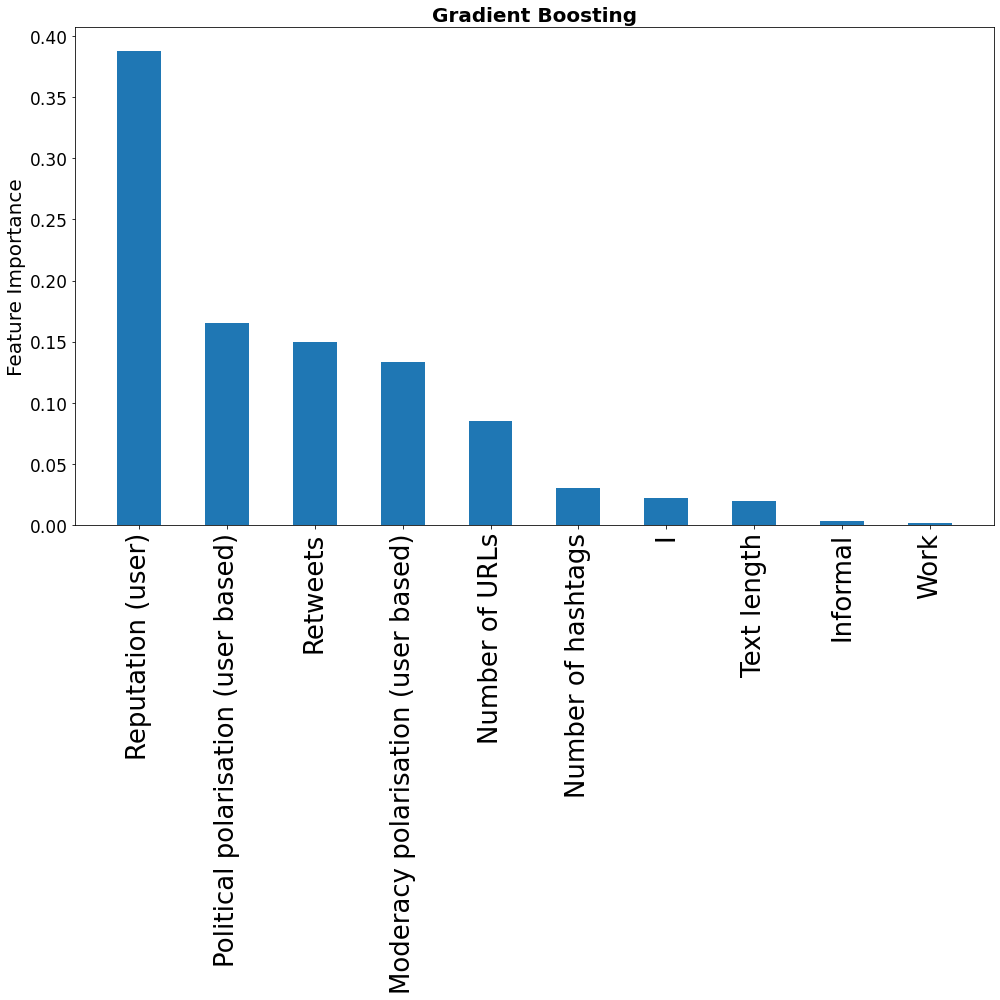

In [18]:
plot_hist_Features(l_features_importances, l_features, 'Gb_tweetscov19_content_user')

************************************************
************************************************

## TweetsCov19
### (Content only)

In [70]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[  'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation' ])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Reputation (user)'])


In [71]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 80)
(200000,)


In [72]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [73]:
%%time
gb_model = fit_gradientboosting_clf(X_train, y_train)
test_gradientboosting_clf(gb_model, X_test, y_test)

NameError: name 'fit_gradientboosting_clf' is not defined

In [74]:
gb_model = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01, loss='exponential')
gb_model.fit(X_train, y_train)

f_importances = features_classifier_(X, gb_model)
f_importances

,index,Feature,importance
0,0,Retweets,0.3937
1,9,Number of URLs,0.2966
2,1,Favorites,0.1031
3,8,Text length,0.0543
4,56,I,0.0437
5,21,Work,0.0315
6,27,Informal,0.0255
7,6,Number of hashtags,0.0209
8,14,Science polarisation (tweet based),0.0082
9,11,Number of Emojis,0.0079


In [31]:
f_importances = f_importances[f_importances['importance'] != 0]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'URLs_num' 'Favorites' 'Text_len' 'i' 'work' 'informal'
 'Hashtags_num' 'tweet_politic_polarisation' 'tweet_science_polarisation'
 'Emoji_num' 'Mentions_num' 'prep' 'Emoji_sent' 'sexual']


In [32]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 15)
(200000,)


In [32]:
%%time
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.1 )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.008
 f1        : 0.61 +/- 0.008
 recall    : 0.63 +/- 0.008
Wall time: 3min 27s


In [33]:
%%time
#200 000 tweets
#Feature importance != 0.0
#(15 Features)

clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.60 +/- 0.003
 f1        : 0.64 +/- 0.001
 recall    : 0.69 +/- 0.006
Wall time: 7min 56s


In [34]:
%%time
#200 000 tweets
#Feature importance != 0.0
#(12 Features)

clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.60 +/- 0.003
 f1        : 0.64 +/- 0.001
 recall    : 0.69 +/- 0.006
Wall time: 7min 55s


********************************************************
********************************************************

## Plot feature Imortances
### TweetsCov19 (Content Only)

In [79]:
def plot_hist_Features_content_only(l_features_importances, l_features, title):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['brown', 'peru', 'black','tan', 'mediumslateblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    #ax.bar(x, l_features_importances, color = colors)
    ax.bar(x, l_features_importances, width=0.5)
    
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=24,  rotation='vertical')
         
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    
    fig.tight_layout()  
    plt.savefig('../plots/'+title+'.pdf')


In [82]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Retweets',
 'Number of URLs',
 'Favorites',
 'Text length',
 'I',
 'Work',
 'Informal',
 'Number of hashtags',
 'Science polarisation (tweet based)',
 'Number of Emojis']

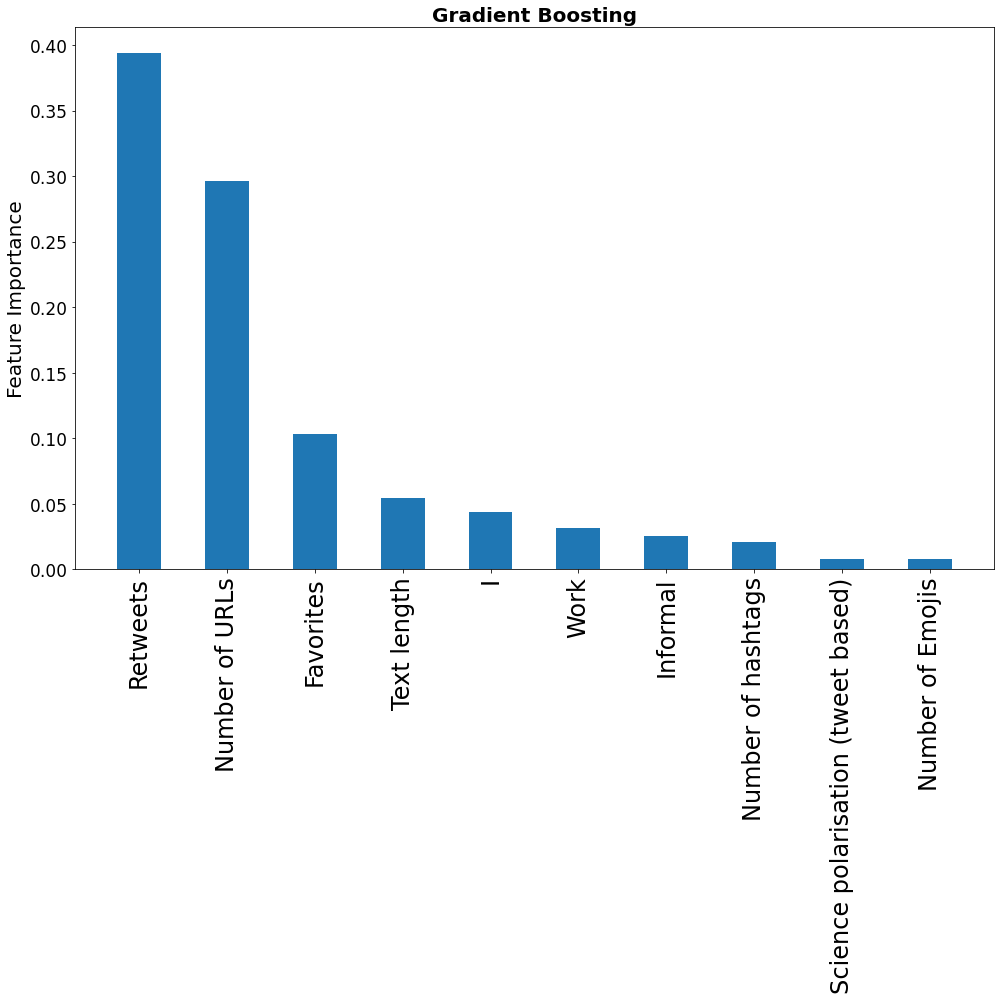

In [83]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Gb_tweetscov19_content_only')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [32]:
path = '../data/df_tweetskb_sample_200000_9.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative', 'Sentiment neutral', 'Sentiment positive', 'Sentiment compound', 'Number of hashtags', 'Number od mentions', 'Text length', 'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent', 'Political polarisation (tweet based)', 'Science polarisation (tweet based)', 'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend', 'Female', 'Male' , 'Work', 'Leisure', 'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk', 'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'compare', 'Interrog', 'Number', 'Quant', 'See', 'Hear', 'Feel', 'Motion', 'Space', 'Time', 'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)', 'Reputation (user)', 'Is_deleted', 'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation'])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1234468305332654080,cacamshx,1,1,-0.0000,1.0000,0.0000,0.0000,0,0,34,0,103.5400,1,0.0000,0.0000,0.0000,0.0000,42.8600,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.5363,True,0.2107,0.0000,0.0000,0.0000,0.0000
1,1232807636535394304,GrammieJustice,0,0,-0.3550,0.6450,0.0000,-0.5106,0,1,71,1,6.3590,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.3613,True,-0.0605,-0.4501,0.0000,0.0000,0.0000
2,1241798055826874368,gguksera,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,35,0,62.7900,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.5345,True,0.1027,0.0000,0.0000,0.0000,0.0000
3,1185748472579780608,WTFMeqs,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,22,0,100.2400,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.1919,True,0.0000,0.0000,0.0000,0.0000,0.0000
4,1247192242084884488,wavikee,1,4,-0.0000,0.8330,0.1670,0.4588,0,1,68,0,66.1000,4,0.3565,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000

In [33]:
features = df_tweetskb_user.columns
#features

In [34]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
199995,1247284461307400200,virtualscones,0,0,-0.0000,0.5520,0.4480,0.7430,0,0,60,0,95.9550,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,8.3300,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,8.3300,8.3300,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,8.3300,16.6700,0.0000,0.0000,0.0000,25.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.3476,0,0.7430,0.0000,0.0000,0.0000,0.0000
199996,1204137626728452096,maxi_why,0,0,-0.2050,0.7950,0.0000,-0.2023,0,0,41,0,82.3900,0,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,12.5000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,12.5000,0.0000,12.5000,0.0000,12.5000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.3703,0,-0.2023,0.0000,0.0000,0.0000,0.0000
199997,1257710175651323916,_AdeAugustine,0,0,-0.4420,0.5580,0.0000,-0.5789,0,0,38,0,82.3900,0,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,12.5000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,0.0000,12.5000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,0,0.0000,0.3828,0,0.2487,-0.8276,0.0000,0.0000,0.0000
199998,1215872861476397056,jodystans,0,0,-0.2710,0.7290,0.0000,-0.3818,0,1,77,0,29.5150,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,9.0900,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5,0,0.0000,0.5587,0,-0.2929,-0.0889,0.0000,0.0000,0.0000
199999,1242155490236403714,DerekRRose,0,0,-0.0000,0.4880,0.5120,0.6369,0,1,28,0,66.4000,0,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0

In [35]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1234847152402202626,vantae707,7,0,-0.0000,1.0000,0.0000,0.0000,3,3,96,0,25.4550,0,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.2706,0,0.0000,0.0000,0.0000,0.0000,0.0000
1,1219445066311311360,successfulbabes,0,0,-0.0000,0.2000,0.8000,0.6124,0,1,15,0,-6.6950,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.4140,0,0.1052,0.5071,0.0000,0.0000,0.0000
2,1209671222335868930,dreamxjess,0,0,-0.0000,0.6010,0.3990,0.8074,0,0,38,0,84.9000,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,12.5000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.2667,1,0.8074,0.0000,0.0000,0.0000,0.0000
3,1264438195816665088,KochGa,0,0,-0.0990,0.7330,0.1680,0.4596,0,0,240,0,89.0830,0,0.0000,0.0000,0.0000,0.0000,19.5700,0.0000,4.3500,4.3500,6.5200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.3500,0.0000,0.0000,2.1700,4.3500,0.0000,2.1700,0.0000,2.1700,2.1700,8.7000,4.3500,2.1700,6.5200,4.3500,2.1700,2.1700,2.1700,0.0000,17.3900,0.0000,0.0000,0.0000,0.0000,8.7000,0.0000,8.7000,4.3500,6.5200,4.3500,10.8700,6.5200,2.1700,21.7400,2.1700,0.0000,2.1700,0.0000,0.0000,2.1700,0.0000,2.1700,2.1700,2.1700,4.3500,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.3558,0,0.4596,0.0000,0.0000,0.0000,0.0000
4,1252074486511386625,deniqtt,0,0,-0.0000,0.8940,0.1060,0.3818,0,0,132,0,110.0550,0,0.0000,0.0000,0.0000,0.0000,15.3800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.8500,3.8500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00

In [36]:
print(len(features))
features

95


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative',
       'Sentiment neutral', 'Sentiment positive', 'Sentiment compound',
       'Number of hashtags', 'Number od mentions', 'Text length',
       'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent',
       'Political polarisation (tweet based)',
       'Science polarisation (tweet based)',
       'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend',
       'Female', 'Male', 'Work', 'Leisure', 'Home', 'Money', 'Relegion',
       'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler',
       'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx',
       'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain',
       'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk',
       'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe',
       'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj',
       'Negate', 'Verb',

In [37]:
#df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)'])

In [38]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 89)
(200000,)


In [39]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [17]:
gb_model = fit_gradientboosting_clf(X_train, y_train)
test_gradientboosting_clf(gb_model, X_test, y_test)

Accuracy : 0.592175


In [18]:
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.49      0.55     19907
           1       0.58      0.69      0.63     20093

    accuracy                           0.59     40000
   macro avg       0.60      0.59      0.59     40000
weighted avg       0.60      0.59      0.59     40000



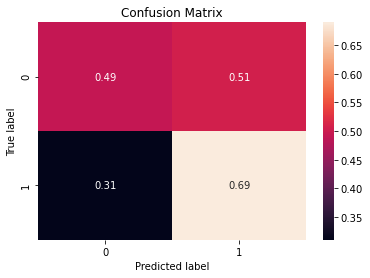

In [19]:
plot_confusion_matrix(y_test, y_pred, gb_model.classes_, 'Confusion Matrix')

In [40]:
gb_model = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  

gb_model.fit(X_train, y_train)

f_importances = features_classifier_(X, gb_model)
f_importances

,index,Feature,importance
0,83,Reputation (user),0.3478
1,0,Retweets,0.1004
2,80,Political polarisation (user based),0.0944
3,55,Focusfuture,0.0728
4,82,Moderacy polarisation (user based),0.0649
5,8,Text length,0.0558
6,9,Number of URLs,0.0446
7,35,Sexual,0.0394
8,84,User sentiment average,0.0347
9,27,Informal,0.0333


In [18]:
f_importances = f_importances[f_importances['importance'] != 0]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'Retweets' 'user_political_polarisation' 'focusfuture'
 'user_moderacy_polarisation' 'Text_len' 'URLs_num' 'sexual' 'informal'
 'user_vadercompound_average' 'Hashtags_num' 'article' 'work' 'Favorites'
 'Mentions_num' 'tweet_moderacy_polarisation_difference' 'Emoji_num'
 'Emoji_sent' 'we' 'tweet_vadercompound_difference'
 'tweet_political_polarisation_difference' 'friend' 'netspeak' 'discrep'
 'vader_com' 'i' 'Vader_neu' 'Vader_neg']


In [19]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 28)
(200000,)


In [32]:
%%time
clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.57 +/- 0.003
 f1        : 0.63 +/- 0.004
 recall    : 0.69 +/- 0.006
Wall time: 14min 23s


In [33]:
%%time
clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.003
 f1        : 0.63 +/- 0.003
 recall    : 0.69 +/- 0.004
Wall time: 38min 11s


*****************************************************
*****************************************************

In [20]:

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

for i in range(len(learning_rate)):

    clf_cv = GradientBoostingClassifier(learning_rate = learning_rate[i] )  
    
    print('learning_rate = ', learning_rate[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

learning_rate =  0.0001
 percision : 0.54 +/- 0.017
 f1        : 0.62 +/- 0.061
 recall    : 0.77 +/- 0.175
---------------------------
learning_rate =  0.001
 percision : 0.55 +/- 0.023
 f1        : 0.60 +/- 0.063
 recall    : 0.69 +/- 0.186
---------------------------
learning_rate =  0.01
 percision : 0.56 +/- 0.010
 f1        : 0.63 +/- 0.011
 recall    : 0.72 +/- 0.038
---------------------------
learning_rate =  0.1
 percision : 0.57 +/- 0.008
 f1        : 0.62 +/- 0.009
 recall    : 0.66 +/- 0.012
---------------------------
learning_rate =  0.2
 percision : 0.57 +/- 0.007
 f1        : 0.61 +/- 0.006
 recall    : 0.65 +/- 0.009
---------------------------
learning_rate =  0.3
 percision : 0.57 +/- 0.008
 f1        : 0.60 +/- 0.009
 recall    : 0.63 +/- 0.012
---------------------------


In [21]:
n_estimators = [100, 200, 300, 400, 500, 1000]

for i in range(len(n_estimators)):

    clf_cv = GradientBoostingClassifier(n_estimators = n_estimators[i], learning_rate= 0.01)
    
    print('n_estimators = ', n_estimators[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

n_estimators =  100
 percision : 0.56 +/- 0.010
 f1        : 0.63 +/- 0.011
 recall    : 0.72 +/- 0.038
---------------------------
n_estimators =  200
 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014
---------------------------
n_estimators =  300
 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.70 +/- 0.012
---------------------------
n_estimators =  400
 percision : 0.57 +/- 0.009
 f1        : 0.62 +/- 0.006
 recall    : 0.69 +/- 0.010
---------------------------
n_estimators =  500
 percision : 0.57 +/- 0.008
 f1        : 0.62 +/- 0.006
 recall    : 0.69 +/- 0.010
---------------------------
n_estimators =  1000
 percision : 0.57 +/- 0.008
 f1        : 0.62 +/- 0.007
 recall    : 0.67 +/- 0.010
---------------------------


In [22]:
m_leafnode = [2,4,8,16,32]

for i in range(len(m_leafnode)):

    clf_cv = GradientBoostingClassifier(n_estimators = 200,  learning_rate= 0.01, max_leaf_nodes = m_leafnode[i])
    print('max_leaf_nodes = ', m_leafnode[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

max_leaf_nodes =  2
 percision : 0.55 +/- 0.006
 f1        : 0.63 +/- 0.006
 recall    : 0.75 +/- 0.014
---------------------------
max_leaf_nodes =  4
 percision : 0.56 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.018
---------------------------
max_leaf_nodes =  8
 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014
---------------------------
max_leaf_nodes =  16
 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014
---------------------------
max_leaf_nodes =  32
 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014
---------------------------


In [23]:
max_depth = [2,4,6,8,10]

for i in range(len(max_depth)):

    clf_cv = GradientBoostingClassifier(n_estimators=200,  learning_rate=0.01, max_leaf_nodes=8, max_depth=max_depth[i])
    print('max_depth = ', max_depth[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

max_depth =  2
 percision : 0.56 +/- 0.008
 f1        : 0.63 +/- 0.006
 recall    : 0.73 +/- 0.021
---------------------------
max_depth =  4
 percision : 0.57 +/- 0.010
 f1        : 0.63 +/- 0.007
 recall    : 0.70 +/- 0.013
---------------------------
max_depth =  6
 percision : 0.57 +/- 0.008
 f1        : 0.63 +/- 0.006
 recall    : 0.70 +/- 0.011
---------------------------
max_depth =  8
 percision : 0.57 +/- 0.008
 f1        : 0.63 +/- 0.006
 recall    : 0.70 +/- 0.010
---------------------------
max_depth =  10
 percision : 0.57 +/- 0.008
 f1        : 0.63 +/- 0.006
 recall    : 0.70 +/- 0.010
---------------------------


In [24]:
clf_cv = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_leaf_nodes=8, loss='deviance' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014


In [25]:
clf_cv = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_leaf_nodes=8, loss='exponential' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.008
 f1        : 0.63 +/- 0.005
 recall    : 0.71 +/- 0.013


In [26]:
clf_cv = GradientBoostingClassifier(n_estimators=20, learning_rate=0.01, max_leaf_nodes=8, criterion='mse' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.54 +/- 0.018
 f1        : 0.62 +/- 0.059
 recall    : 0.76 +/- 0.171


In [27]:
clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8,criterion='squared_error')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014


In [28]:
clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8, max_features = 'auto')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.63 +/- 0.006
 recall    : 0.71 +/- 0.014


In [29]:
clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8, max_features= 'sqrt')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.008
 f1        : 0.62 +/- 0.005
 recall    : 0.69 +/- 0.009


In [30]:
clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8, max_features= 'log2')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.007
 f1        : 0.62 +/- 0.004
 recall    : 0.68 +/- 0.009


***

In [22]:
%%time
#200 000 tweets


clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.56 +/- 0.003
 f1        : 0.64 +/- 0.003
 recall    : 0.73 +/- 0.006
Wall time: 34min 44s


In [20]:
%%time
#200 000 tweets


clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.003
 f1        : 0.64 +/- 0.003
 recall    : 0.74 +/- 0.005
Wall time: 1h 15min 55s


****

## Plot feature Imortances
### Tweetkb (Content + User)

In [44]:
def plot_hist_Features_kb(l_features_importances, l_features, title):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'brown', 'green', 'Indigo', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    #ax.bar(x, l_features_importances, color = colors)
    ax.bar(x, l_features_importances, width=0.5)

    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

   
    fig.tight_layout()
    #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [45]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Reputation (user)',
 'Retweets',
 'Political polarisation (user based)',
 'Focusfuture',
 'Moderacy polarisation (user based)',
 'Text length',
 'Number of URLs',
 'Sexual',
 'User sentiment average',
 'Informal']

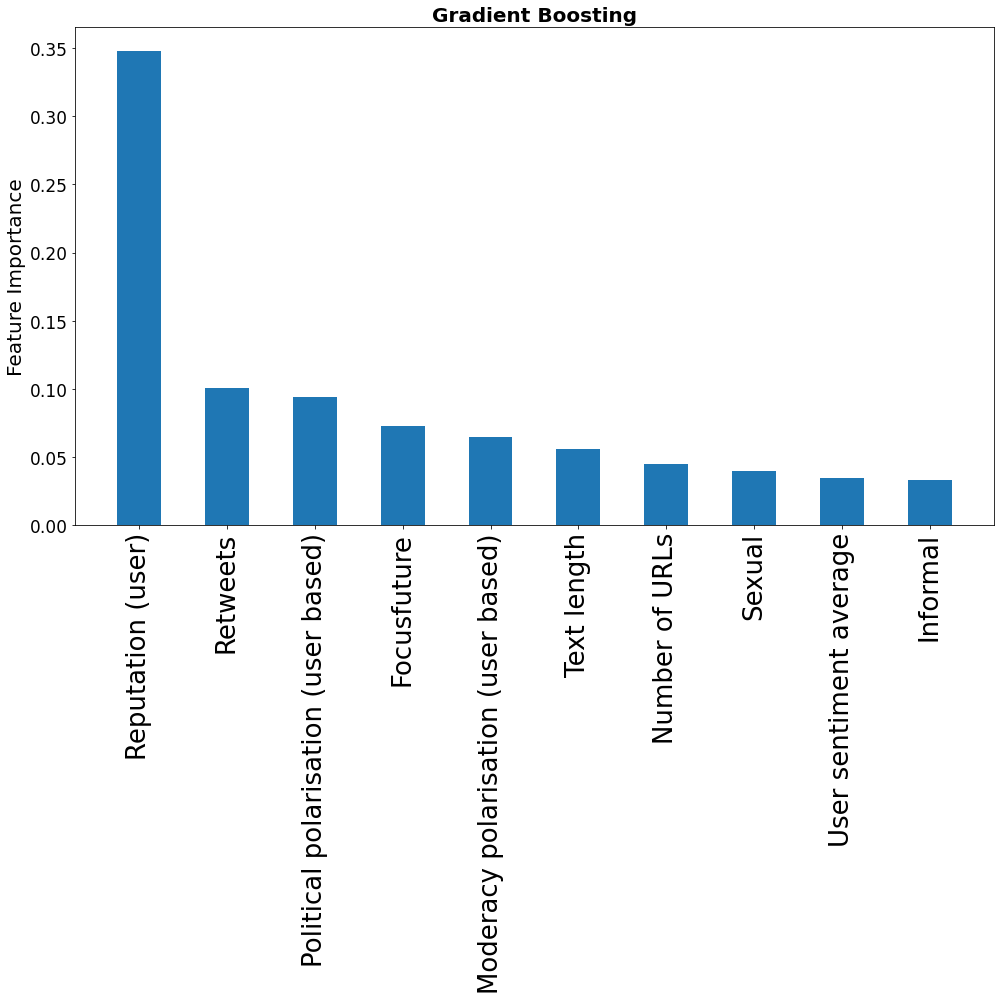

In [46]:
plot_hist_Features_kb(l_features_importances, l_features, 'Gb_tweetskb_content_user')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [22]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Reputation (user)'])


In [23]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 80)
(200000,)


In [24]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [25]:
gb_model = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
gb_model.fit(X_train, y_train)

f_importances = features_classifier_(X, gb_model)
f_importances

,index,Feature,importance
0,1,Favorites,0.2026
1,0,Retweets,0.1791
2,55,Focusfuture,0.1191
3,9,Number of URLs,0.1099
4,8,Text length,0.0756
5,27,Informal,0.0682
6,35,Sexual,0.0593
7,62,Article,0.0516
8,21,Work,0.0437
9,6,Number of hashtags,0.0300


In [28]:
f_importances = f_importances[f_importances['importance'] != 0]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'Favorites' 'URLs_num' 'focusfuture' 'Text_len' 'informal'
 'sexual' 'work' 'article' 'Mentions_num' 'Hashtags_num' 'Emoji_num'
 'tweet_politic_polarisation' 'vader_com' 'Vader_pos' 'ipron' 'netspeak'
 'Emoji_sent' 'we' 'i' 'body' 'focuspast']


In [30]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 22)
(200000,)


In [31]:
%%time
#200 000 tweets


clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.56 +/- 0.003
 f1        : 0.63 +/- 0.004
 recall    : 0.71 +/- 0.007
Wall time: 23min 9s


In [32]:
%%time
#200 000 tweets


clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.003
 f1        : 0.63 +/- 0.004
 recall    : 0.71 +/- 0.007
Wall time: 1h 3min 18s


***************************************************
***************************************************

## Plot feature Imortances
### Tweetskb (Content Only)

In [29]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, title):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    #colors = ['brown','khaki', 'lightsalmon', 'lightskyblue', 'maroon']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,12]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width=0.5)
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=13)

    fig.tight_layout()
    plt.savefig('../plots/'+title+'.pdf')


In [30]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Favorites',
 'Retweets',
 'Focusfuture',
 'Number of URLs',
 'Text length',
 'Informal',
 'Sexual',
 'Article',
 'Work',
 'Number of hashtags']

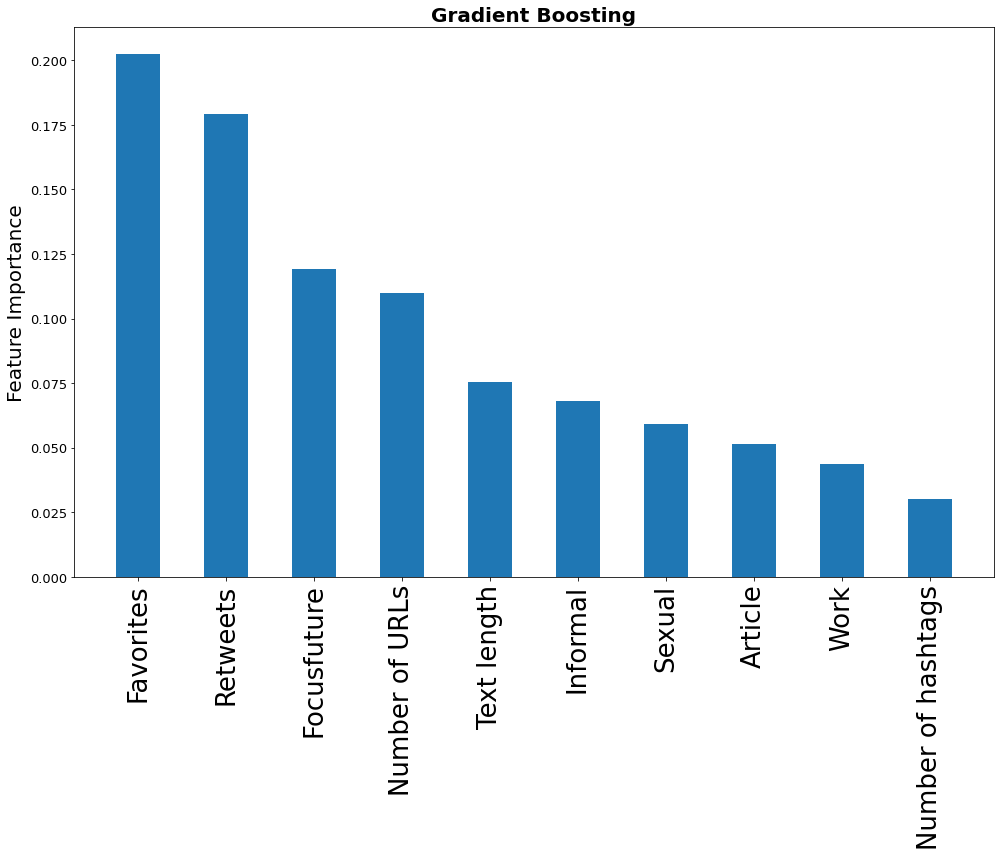

In [31]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Gb_tweetskb_content_only')